In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import datetime 
# norm
import scipy.stats as stats
# optimzie
import scipy.optimize as optimize
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('./data/TSLA.csv')
# Date,Open,High,Low,Close,Adj Close,Volume
df = df.sort_values('Date')
df = df.reset_index(drop=True)
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
# just get the close price
df = df[['Date', 'Close']]
df = df.set_index('Date')
df = df.resample('D').ffill()
# np array
data = df['Close'].values
data = data.reshape(-1, 1)

In [3]:
# Estimate historical volatility of the data 
returns = np.log(data[1:] / data[:-1])
r_bar = np.mean(returns)
std = np.std(returns)
# 6 months = T
T = (1/2) * 252
N = len(returns)
volatility = np.sqrt ( (T / (N - 1)) * np.sum((returns - r_bar)**2) )
print('Historical Volatility:', volatility)

Historical Volatility: 0.2676814905073086


In [4]:
# Use the binomial tree approach to estimate the price of a Jun 2024 European call option , where 𝑟 = 0.05 ,
# 𝑆0 = 𝑐𝑢𝑟𝑟𝑒𝑛𝑡 𝑝𝑟𝑖𝑐𝑒 ,𝐾 = 𝑆0 + $50
# TTSLA Jun 21 2024 150.000 call
# prices = data
# r = 0.05
# S0 = prices[-1]
# K = S0 + 50
# T = 2
# sigma = 0.9390


prices = data
r = 0.05
S0 = prices[-1]
K = S0 + 50
# get days until expiration
days = (datetime.datetime(2024, 6, 21) - datetime.datetime(2022, 6, 21)).days
T = days / 252
sigma = volatility

# Binomial tree
def binomial_tree(S0, K, T, r, sigma, N, option_type='call'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    prices = np.zeros((N + 1, N + 1))
    prices[0, 0] = S0[0] if isinstance(S0, np.ndarray) else S0

    for i in range(1, N + 1):
        prices[i, 0] = prices[i - 1, 0] * u
        for j in range(1, i + 1):
            prices[i, j] = prices[i - 1, j - 1] * d
    option_prices = np.zeros((N + 1, N + 1))
    if option_type == 'call':
        option_prices[-1] = np.maximum(prices[-1] - K, 0)
    else:
        option_prices[-1] = np.maximum(K - prices[-1], 0)
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_prices[i, j] = np.exp(-r * dt) * (p * option_prices[i + 1, j] + (1 - p) * option_prices[i + 1, j + 1])
    return option_prices[0, 0]

N = 100
option_price = binomial_tree(S0, K, T, r, sigma, N)
print('Binomial Tree Option Price:', option_price)

Binomial Tree Option Price: 18.380880505010143


In [5]:
# Investigate the convergence rate of the binomial method as a function of the number of partitions of your time
# to expiration. Draw a graph

N = np.arange(10, 1000, 10)
option_prices = []
for n in N:
    option_price = binomial_tree(S0, K, T, r, sigma, n)
    option_prices.append(option_price)

# horizontal dashed red line for the converging price
plt.axhline(y=option_prices[-1], color='r', linestyle='--')
plt.plot(N, option_prices)
plt.xlabel('Number of Partitions')
plt.ylabel('Option Price')
plt.title('Binomial Tree Option Price Convergence')
plt.show()

In [ ]:
# Use the binomial tree approach to estimate the price of a Jun 2024 American put option , where 𝑟 = 0.05 ,
# 𝑆0 = 𝑐𝑢𝑟𝑟𝑒𝑛𝑡 𝑝𝑟𝑖𝑐𝑒 ,𝐾 = 𝑆0 + $50
# TTSLA Jun 21 2024 150.000 put

K = S0 + 50
prices = data
r = 0.05
S0 = prices[-1]
T = days / 252
sigma = volatility
N = 100

option_price = binomial_tree(S0, K, T, r, sigma, N, option_type='put')
print('Binomial Tree Option Price:', option_price)

Binomial Tree Option Price: 41.77675909788556


In [ ]:
# e) Use B-S formula to calculate the price of a Jun 2024 European call option , where 𝑟 = 0.05 , 𝑆0 =
# 𝑐𝑢𝑟𝑟𝑒𝑛𝑡 𝑝𝑟𝑖𝑐𝑒 ,𝐾 = 𝑆0 + $50. Use the put-call parity relation to calculate the price of a corresponding put
# option. Calculate the Delta, Gamma, Vega, rho of this option at the start of the option’s life.

def black_scholes(S0, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S0 * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * stats.norm.cdf(-d2) - S0 * stats.norm.cdf(-d1)
    return price


S0 = prices[-1]
K = S0 + 50
T = days / 252
r = 0.05
sigma = volatility

call_price = black_scholes(S0, K, T, r, sigma)
put_price = black_scholes(S0, K, T, r, sigma, option_type='put')
print('Black-Scholes Call Option Price:', call_price)
print('Black-Scholes Put Option Price:', put_price)

Black-Scholes Call Option Price: [18.38632482]
Black-Scholes Put Option Price: [41.78220341]


In [ ]:
delta = (black_scholes(S0 + 0.01, K, T, r, sigma) - black_scholes(S0 - 0.01, K, T, r, sigma)) / 0.02
gamma = (black_scholes(S0 + 0.01, K, T, r, sigma) - 2 * black_scholes(S0, K, T, r, sigma) + black_scholes(S0 - 0.01, K, T, r, sigma)) / 0.01**2
vega = (black_scholes(S0, K, T, r, sigma + 0.01) - black_scholes(S0, K, T, r, sigma - 0.01)) / 0.02
rho = (black_scholes(S0, K, T, r + 0.01, sigma) - black_scholes(S0, K, T, r - 0.01, sigma)) / 0.02

print('Delta:', delta)
print('Gamma:', gamma)
print('Vega:', vega)
print('Rho:', rho)

Delta: [0.46180193]
Gamma: [0.0059234]
Vega: [99.44887417]
Rho: [143.63108982]


Monte Carlo Option Price: 0.0


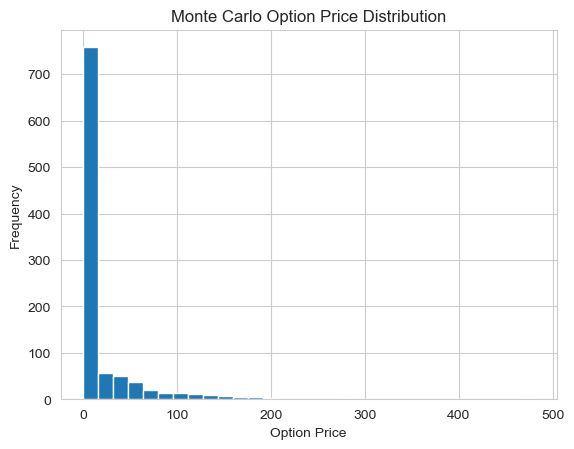

In [ ]:
# Use a simple Monte Carlo method to estimate the price of a Jun 2024 European call option, where 𝑟 = 0.05
# 𝑆0 = 𝑐𝑢𝑟𝑟𝑒𝑛𝑡 𝑝𝑟𝑖𝑐𝑒 ,𝐾 = 𝑆0 + $50. Compare your answer with parts b) and e)

def monte_carlo(S0, K, T, r, sigma, N, option_type='call'):
    dt = T / N
    prices = np.zeros(N + 1)
    prices[0] = S0[0] if isinstance(S0, np.ndarray) else S0
    for i in range(1, N + 1):
        prices[i] = prices[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal())
    if option_type == 'call':
        payoff = np.maximum(prices[-1] - K, 0)
    else:
        payoff = np.maximum(K - prices[-1], 0)
    price = np.exp(-r * T) * np.mean(payoff)
    return price

S0 = prices[-1]
K = S0 + 50
T = days / 252
r = 0.05
sigma = volatility
N = 1000

option_price = monte_carlo(S0, K, T, r, sigma, N)
print('Monte Carlo Option Price:', option_price)

# plot a histogram of the option prices
option_prices = [monte_carlo(S0, K, T, r, sigma, N) for _ in range(1000)]

plt.hist(option_prices, bins=30)
plt.xlabel('Option Price')
plt.ylabel('Frequency')
plt.title('Monte Carlo Option Price Distribution')
plt.show()

Monte Carlo Antithetic Option Price: 0.0


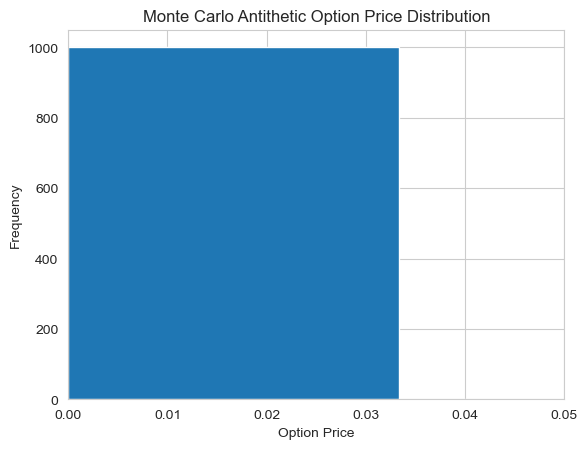

In [ ]:
# g) Use a Monte Carlo method with Antithetic variates to estimate the price of a Jun 2024 European call option,
# where 𝑟 = 0.05 , 𝑆0 = 𝑐𝑢𝑟𝑟𝑒𝑛𝑡 𝑝𝑟𝑖𝑐𝑒 ,𝐾 = 𝑆0 + $50. 

def monte_carlo_antithetic(S0, K, T, r, sigma, N, option_type='call'):
    dt = T / N
    prices = np.zeros(N + 1)
    prices[0] = S0[0] if isinstance(S0, np.ndarray) else S0
    for i in range(1, N + 1):
        z1 = np.random.normal()
        z2 = -z1
        prices[i] = prices[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z1)
        prices[i] += prices[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z2)
        prices[i] /= 2
    if option_type == 'call':
        payoff = np.maximum(prices[-1] - K, 0)
    else:
        payoff = np.maximum(K - prices[-1], 0)
    price = np.exp(-r * T) * np.mean(payoff)
    return price

S0 = prices[-1]
K = S0 + 50
T = days / 252
r = 0.05
sigma = volatility
N = 1000

option_price = monte_carlo_antithetic(S0, K, T, r, sigma, N)
print('Monte Carlo Antithetic Option Price:', option_price)

# plot a histogram of the option prices
option_prices = [monte_carlo_antithetic(S0, K, T, r, sigma, N) for _ in range(1000)]

plt.hist(option_prices, bins=30)
plt.xlim([0.0, 0.05])
plt.xlabel('Option Price')
plt.ylabel('Frequency')
plt.title('Monte Carlo Antithetic Option Price Distribution')
plt.show()

In [ ]:
# Use a Monte Carlo method with Control variables to estimate the price of a Jun 2024 European call option,
# where 𝑟 = 0.05 , 𝑆0 = 𝑐𝑢𝑟𝑟𝑒𝑛𝑡 𝑝𝑟𝑖𝑐𝑒 ,𝐾 = 𝑆0 + $50. Compare f), g), h)

def monte_carlo_control(S0, K, T, r, sigma, N, option_type='call'):
    dt = T / N
    prices = np.zeros(N + 1)
    prices[0] = S0[0] if isinstance(S0, np.ndarray) else S0
    for i in range(1, N + 1):
        z = np.random.normal()
        prices[i] = prices[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    if option_type == 'call':
        payoff = np.maximum(prices[-1] - K, 0)
    else:
        payoff = np.maximum(K - prices[-1], 0)
    price = np.exp(-r * T) * np.mean(payoff)
    return price

S0 = prices[-1]
K = S0 + 50
T = days / 252
r = 0.05
sigma = volatility
N = 1000

option_price = monte_carlo_control(S0, K, T, r, sigma, N)
print('Monte Carlo Control Option Price:', option_price)

# plot a histogram of the option prices
option_prices = [monte_carlo_control(S0, K, T, r, sigma, N) for _ in range(1000)]

plt.hist(option_prices, bins=30)
plt.xlabel('Option Price')
plt.ylabel('Frequency')
plt.title('Monte Carlo Control Option Price Distribution')
plt.show()

In [ ]:
# i) Estimate the implied volatility for the problem in part e). How does it compare with the historical volatility?
 
def implied_volatility(S0, K, T, r, price, option_type='call'):
    def f(sigma):
        return black_scholes(S0, K, T, r, sigma, option_type) - price
    return optimize.newton(f, 0.5)

S0 = prices[-1]
K = S0 + 50
T = days / 252
r = 0.05
price = call_price

implied_vol = implied_volatility(S0, K, T, r, price)
print('Implied Volatility:', implied_vol)
